Вихідні дані

Тестовий пакет – MIRFlickr-20k (https://press.liacs.nl/mirflickr/#sec_download)
Вибірка зображень – 250 зображень;
Формування вибірки зображень – псевдовипадкове, з використанням генератора Мерсена (стартове значення співпадає з номером студента в загальному списку групи) за модулем кількості зображень в тестовому пакеті.

Лабораторна робота №1
1)	Сформувати тестову вибірку зображень з вихідного пакету;


In [1]:
import numpy as np
import pandas as pd

import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error
from statsmodels.stats.weightstats import DescrStatsW
import warnings
warnings.filterwarnings('ignore')

os.chdir('C:\\DS\\datasets\\mirflickr')# all datasets will be stored outside of a project
total_students = 10
student_num = 3%total_students

To select a sample we'll use numpy.random module, an implementation of Mersenne Twister pseudorandom generator based on [MT19937 algorithm](https://en.wikipedia.org/wiki/Mersenne_Twister). It's worth mentioning that python's random module is identwarningsl

In [2]:
contents = os.listdir()
images_names = np.array([c for c in contents if c.endswith('.jpg')])

# np.seed(student_num)
generator = np.random.RandomState(seed=student_num)# works the same as np.seed()

total_images = images_names.shape[0]
sample_size = 250

sample_images_names = generator.choice(images_names,sample_size) 

print(f'selected sample of {sample_size} images from {total_images} images in total')

selected sample of 250 images from 25000 images in total


To read the images we'll use opencv, which by default reads image in B,G,R order. 
* cv.imread(file) reads image as an ndarray of shape (height,width,3)
* cv.split() splits ndarray into three 2D arrays (B,G,R) of shape (height,width), from which we select array G



In [3]:
def get_brightness_distribution(channel='green',index=None):
    """
    Arguments:
        channel: ['red', 'green', 'blue']
        index -- image index
    
    Returns:
        pixels_list -- list of pixels of a selected channel; by default of all images
        brightness_distribution -- Series of counts of occurences of each pixel in a pixels_list; 
    
    """
    channel_dict = {'red':0,
                    'green':1,
                    'blue':2}
    try:
        ind = channel_dict[channel]
    except KeyError:
        print(f"channel can be 'red' or 'green' or 'blue'")
        return
    
    if index is not None:
        pixels_list = cv2.split(cv2.imread(sample_images_names[index]))[ind].reshape(-1)
    
    else:
        sample_images_channel = np.array([cv2.split(cv2.imread(img))[ind] for img in sample_images_names])
        pixels_list = np.concatenate([img.flatten() for img in sample_images_channel])   
    bincount = np.bincount(pixels_list)
    
    pixels_value_counts = np.zeros(256,dtype=int)#some images don't contain the brightest pixels and have to be padded
    pixels_value_counts[:bincount.shape[0]] = bincount
    
    brightness_distribution = pd.Series(data=pixels_value_counts, index=np.arange(256), name=channel)
    
    return pixels_list, brightness_distribution

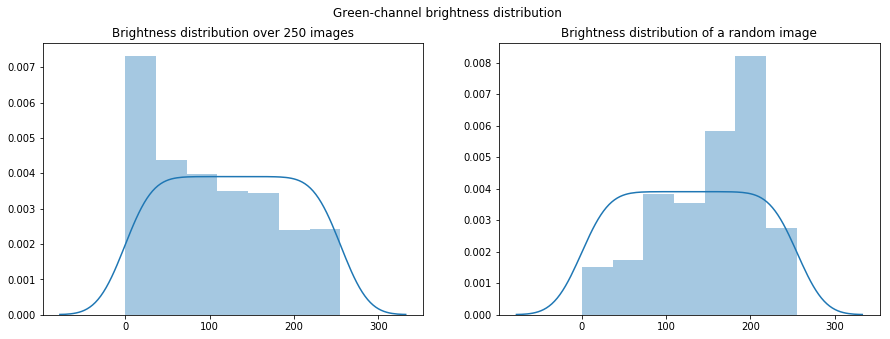

In [4]:
green_pixels_list, brightness_distribution_green = get_brightness_distribution() #list of all pixels for all images
brightness_distribution_list = [get_brightness_distribution(index=i)[1] for i in range(len(sample_images_names))]# list separate distributions for each image

plt.figure(figsize=(15,5))
plt.suptitle('Green-channel brightness distribution')
plt.subplot(121)
plt.title('Brightness distribution over 250 images')
sns.distplot(brightness_distribution_green.keys(),hist_kws={'weights':brightness_distribution_green.values});#example 


plt.subplot(122)
plt.title('Brightness distribution of a random image')
sns.distplot(brightness_distribution_list[42].keys(),hist_kws={'weights':brightness_distribution_list[42].values});#example 

2)	Для зеленого каналу кольору тестових зображень обчислити наступні характеристики розподілу значень яскравості пікселів:<br>
* 	Математичне очікування та дисперсію:

* In this part we'll calculate all the characteristics for a joint distribution of all images

In [5]:
weightstats = DescrStatsW(brightness_distribution_green.keys(),weights=brightness_distribution_green.values)
avg = np.average(brightness_distribution_green.keys(),weights=brightness_distribution_green.values)
assert avg==green_pixels_list.mean()
np.testing.assert_almost_equal(np.average((brightness_distribution_green.keys()-avg)**2,weights=brightness_distribution_green.values),np.var(green_pixels_list))

mean, variance = weightstats.mean, weightstats.var
print(f'green channel of 250 images has a mean of {mean:.4f} and a variance of {variance:.4f}')

green channel of 250 images has a mean of 100.9230 and a variance of 5702.3071


* 	Медіану та інтерквартильний розмах;

In [6]:
median,iqr = np.median(green_pixels_list), np.subtract(*np.percentile(green_pixels_list,[75,25]))
print(f'green channel of 250 images has a median of {median} and an IQR of {iqr}')

green channel of 250 images has a median of 90.0 and an IQR of 127.0


* 	Коефіцієнти асиметрії та ексцесу (нормалізований);

In [7]:
skewness,kurtosis = stats.skew(green_pixels_list),stats.kurtosis(green_pixels_list)
print(f'green channel of 250 images has a skew of {skewness:.4f} and kurtosis coeff of {kurtosis:.4f}')

green channel of 250 images has a skew of 0.3841 and kurtosis coeff of -0.9989


* 	Гістограму значень яскравості пікселів (нормалізовану);

3)	Провести обробку отриманих гістограм: 
*	Провести апроксимацію гістограм з використанням імовірнісних розподілів:
 *      i)	Нормального (гаусового) розподілу;
 *      ii)	Розподілу Лапласа;
 *      iii)	Розподілу Стьюдента;
 *      iv)	Бета розподілу;


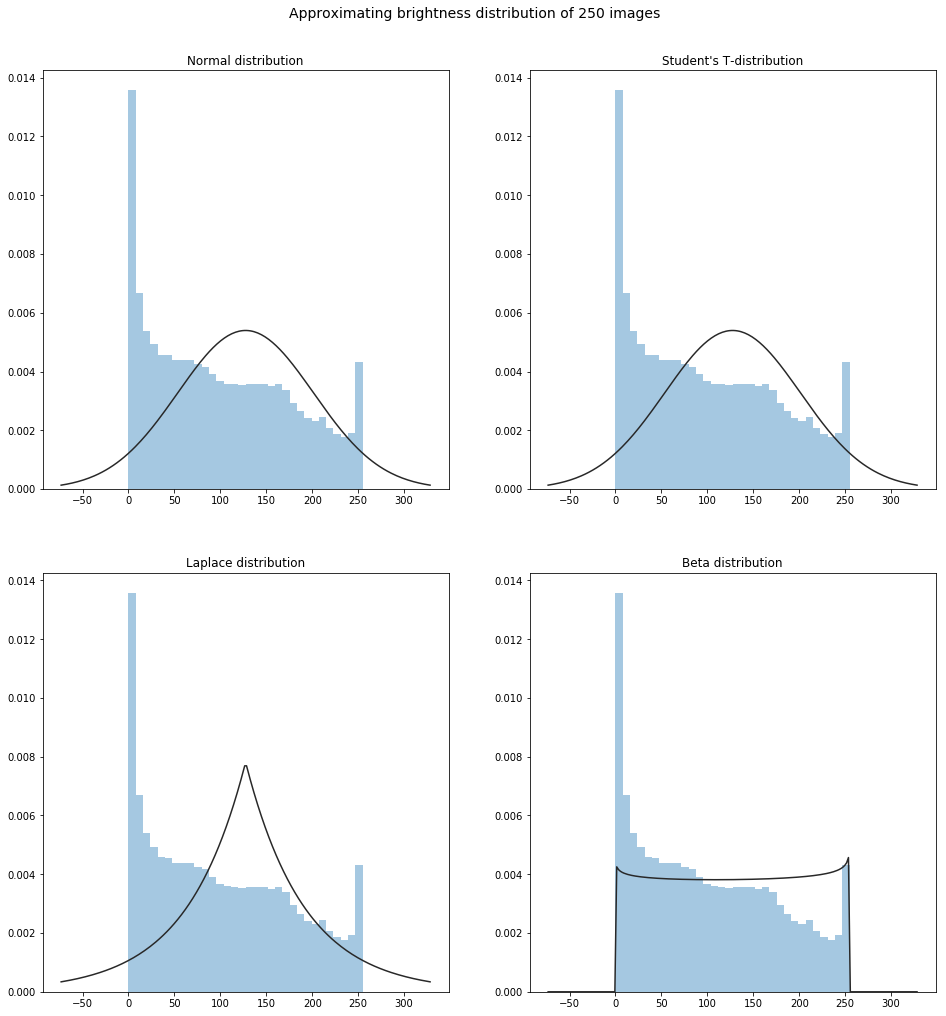

In [8]:
plt.figure(figsize=(16,16))

plt.subplots_adjust(top=0.925)
plt.suptitle('Approximating brightness distribution of 250 images',fontsize=14)
plt.subplot(221)
plt.title("Normal distribution")
sns.distplot(brightness_distribution_green.keys(), bins=32, hist_kws={'weights':brightness_distribution_green.values},norm_hist=True,fit=stats.norm,kde=False) 

plt.subplot(222)
plt.title("Student's T-distribution")
sns.distplot(brightness_distribution_green.keys(), bins=32, hist_kws={'weights':brightness_distribution_green.values},norm_hist=True,fit=stats.t,kde=False) 

plt.subplot(223)
plt.title("Laplace distribution")
sns.distplot(brightness_distribution_green.keys(), bins=32, hist_kws={'weights':brightness_distribution_green.values},fit=stats.laplace,kde=False) 

plt.subplot(224)
plt.title("Beta distribution")
sns.distplot(brightness_distribution_green.keys(), bins=32, hist_kws={'weights':brightness_distribution_green.values},fit=stats.beta,kde=False);

* 	Для кожної гістограми визначити найкращий тип апроксимуючого розподілу за критерієм мінімізації середньо квадратичного відхилення;

In [9]:
def calculate_mse(brightness_distribution,distribution='norm'):
    space = np.linspace(0,255,num=256)
    if distribution=='norm':
        pdf = stats.norm.pdf(space,*stats.norm.fit(brightness_distribution.values))#wrong fit
    elif distribution == "t":
        pdf = stats.t.pdf(space,*stats.t.fit(brightness_distribution.values))
    elif distribution =='laplace':
        pdf = stats.laplace.pdf(space,*stats.laplace.fit(brightness_distribution.values))
    elif distribution == 'beta':
        pdf = stats.beta.pdf(space,*stats.beta.fit(brightness_distribution.values))
        
    predicted = pdf * brightness_distribution.values.sum()
    return mean_squared_error(brightness_distribution.values,predicted)

def get_best_dist(brightness_dist):
    distributions = ['norm','t','laplace','beta']
    mse_dict = {d: calculate_mse(brightness_dist,distribution=d) for d in distributions}
    min_dist = min(mse_dict, key=lambda k: mse_dict[k])
    
    return (min_dist, round(mse_dict[min_dist],2))

In [10]:
best_dist_dict = {ind+1: get_best_dist(brightness_distribution_list[ind]) for ind in range(len(brightness_distribution_list))}
best_distribution_df = pd.DataFrame.from_dict(best_dist_dict,orient='index',columns=['Best distribution','MSE'])
best_distribution_df.index.rename('Image',inplace=True)
best_distribution_df

,Best distribution,MSE
Image,,
1,beta,222051.80
2,norm,532780.79
3,laplace,6154256.83
4,norm,867847.62
5,laplace,781983.95
...,...,...
246,t,1048228.48
247,beta,1770899.04
248,laplace,545952.16


*	Побудувати розподіл отриманих апроксимацій за видом апроксимуючого розподілу;

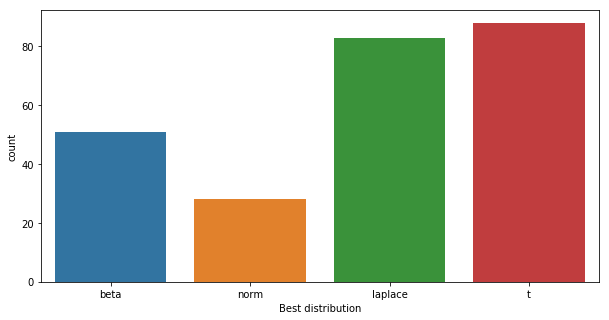

In [11]:
plt.figure(figsize=(10,5))
sns.countplot(best_distribution_df['Best distribution']);

4)	Побудувати багатовимірні гаусові моделі:
*	Сформувати вектори параметрів розподілу значень яскравості пікселів тестових зображень;
    *   i)	Математичне очікування;
    *   ii)	Математичне очікування та дисперсія;
    *   iii)	Математичне очікування, дисперсія та коефіцієнт асиметрії;
    *    iv)	Математичне очікування, дисперсія, коефіцієнти асиметрії та ексцесу;


In [12]:
blue_pixels_list, brightness_distribution_blue = get_brightness_distribution('blue')
red_pixels_list, brightness_distribution_red = get_brightness_distribution('red')

In [13]:
multivariate_brightness_distribution =  pd.concat([brightness_distribution_red,brightness_distribution_green,brightness_distribution_blue],axis=1)
multivariate_brightness_distribution.head()

,red,green,blue
0,2457684,1866496,1821026
1,763983,636833,599995
2,688135,474925,452422
3,576455,370288,386135
4,571940,352994,385018


In [14]:
dsw = DescrStatsW(multivariate_brightness_distribution.index,weights=multivariate_brightness_distribution[multivariate_brightness_distribution.columns[0]])

*	Визначити параметри багатовимірних гаусових моделей для кожної групи векторів, відобразити їх графічно та у вигляді таблиць.

*   Підготувати звіт за отриманими результатами лабораторної роботи.